## Aim
To find probability of customer's default using bank's data

### Description of features:

* `client_id` - client identifier
* `app_date` - date of applicate order
* `education` - level of education
* `sex` - sex of borrower
* `age` - age of borrower
* `car` - is there car or not?
* `car_type` - type of car
* `decline_app_cnt` - quantity of previous rejected requests
* `good_work` - is there good work or not?
* `score_bki` - score from credit bureau
* `bki_request_cnt` - quantity of requests in credit bureau
* `home_address` - home address like category 
* `work_address` - work address like category
* `income` - income of borrower
* `foreign_passport` - is there foreign passport or not?
* `sna` - is the relation between borrower and bank or not?
* `first_time` - First time when borrower borrow money
* `region_rating` - rating of region, when borrower live
* `default` - is this client default/bankrupt or not?

## 1. Import libraries

In [771]:
from pandas import Series
import pandas as pd
import numpy as np
from math import floor
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, accuracy_score, precision_score, recall_score, mean_squared_error, plot_confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dfds40-credit-scoring-brovarnik-anatoliy/sf-ds-40-credit-scoring-brovarnik-anatoliy.ipynb
/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


## 2. Import data

In [697]:
data_train = pd.read_csv("/kaggle/input/sf-dst-scoring/train.csv")
data_test = pd.read_csv("/kaggle/input/sf-dst-scoring/test.csv")

display(data_train.head())
print("Shape: ", data_train.shape)
display(data_test.head())
print("Shape: ", data_test.shape)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Shape:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


Shape:  (36349, 18)


### 2.1. Merging datasets

In [698]:
# Set Train and Test data
data_train['train'] = 1 
data_test['train'] = 0

# Merging datasets
data = data_train.append(data_test, sort=False).reset_index(drop=True)

## 3. Exploratory data analysis

In [699]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

None

<AxesSubplot:>

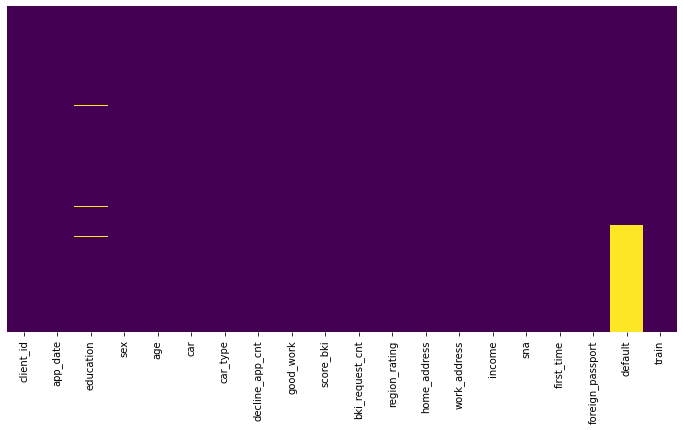

In [700]:
# Let's see where and how many missing data we have
plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

### Brief summary
As we can see data has missing in education and default (here beacause we added test data without information about default)

## 4. Features analysis

In [701]:
# Making list of features dividing by types
# Numeric features
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']
# Categorical features
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# Binary features
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# Time
time_cols = ['app_date']

In [702]:
#  Function to draw charts for numric : distribution and boxplot
def charts_numeric(columns):
    length = len(columns)
    for i in range(0, length):
        df = data[data['train'] == 1][columns[i]]
        fig, ax = plt.subplots(1, 2, figsize=(6,3))
        fig.suptitle("Column: "+columns[i])
        sns.histplot(ax=ax[0], data=df, kde=False)
        sns.boxplot(ax=ax[1], data=df, orient='v')

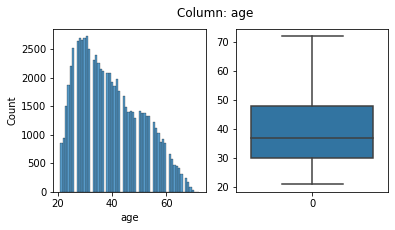

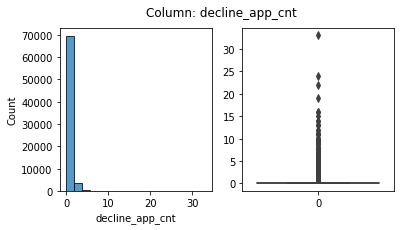

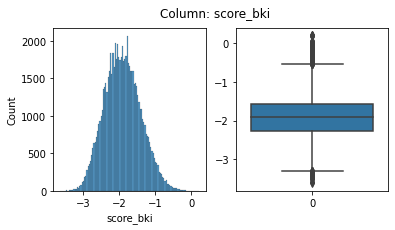

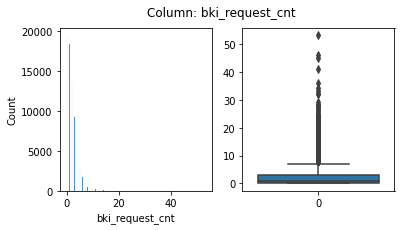

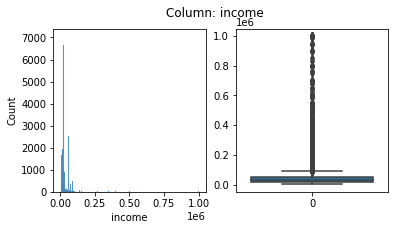

In [703]:
charts_numeric(num_cols)

* All features (except `age`) have outliers, but we won't be remove this data
* Also we can noticed that all features (except `score_bki`) have non-normal distribution, that's why we will apply logarithm

<AxesSubplot:>

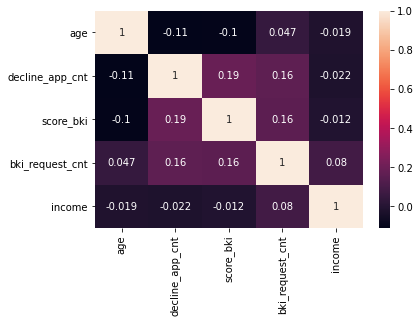

In [704]:
sns.heatmap(data[num_cols].corr(), annot=True)

We don't see big correlation between numeric columns, that's why we'll all them

Let see importance of our features

<AxesSubplot:>

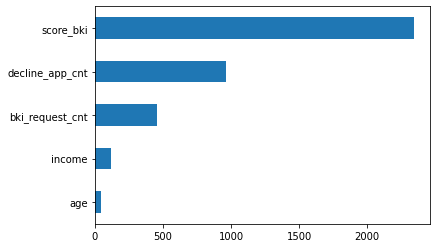

In [705]:
data_imp = data[data['train']==1]
imp_num = Series(f_classif(data_imp[num_cols], data_imp['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Brief summary
Score of BKI it's most important feature

Apply logarithm to numeric columns

In [706]:
num_cols_log = ['age','decline_app_cnt','bki_request_cnt','income']

for col in num_cols_log:
    data[col] = np.log(data[col]+1)

In [707]:
# Categorical features
# cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
def charts_categorical(columns):
    length = len(columns)
    fig, ax = plt.subplots(1, length, figsize=(18,3))
    fig.tight_layout(pad=2)
    for i in range(0,length):
        col_data = data[data['train'] == 1]
        sns.countplot(data=col_data, ax=ax[i], x=columns[i])
        ax[i].set_ylabel("")

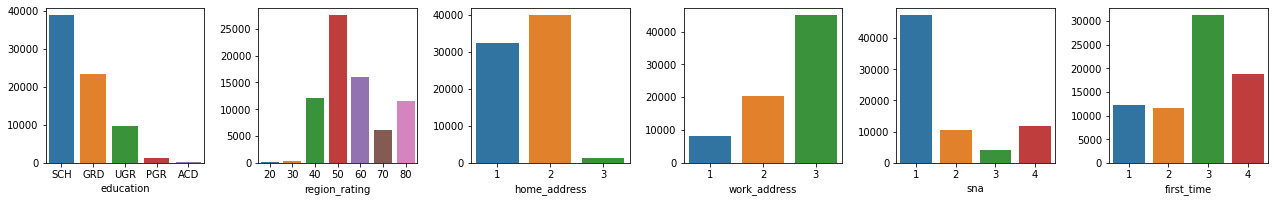

In [708]:
charts_categorical(cat_cols)

Education has missing data

In [709]:
data['education'].value_counts(dropna=False)

SCH    57998
GRD    34768
UGR    14748
PGR     1865
NaN      478
ACD      291
Name: education, dtype: int64

Replace them by most frequency data

In [710]:
data['education'].fillna(value=data['education'].mode()[0], inplace=True)

Field with datetime information

In [711]:
# time_cols = ['app_date']
data['app_date'] = pd.to_datetime(data['app_date'])
display(data['app_date'].head(5))

0   2014-02-01
1   2014-03-12
2   2014-02-01
3   2014-01-23
4   2014-04-18
Name: app_date, dtype: datetime64[ns]

Our dataset has not so big. Just 4 months.

In [712]:
print("start: {}, end: {}".format(data['app_date'].min(), data['app_date'].max()))

start: 2014-01-01 00:00:00, end: 2014-04-30 00:00:00


Let's look to disribution of dates

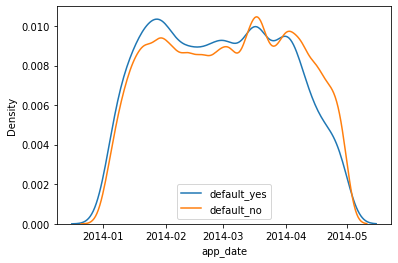

In [713]:
apdate = data[data['train']==1]
sns.kdeplot(apdate[apdate['default']==1]['app_date'].sort_values(), label='default_yes')
sns.kdeplot(apdate[apdate['default']==0]['app_date'].sort_values(), label='default_no')
plt.legend()

For categorical fetures we will be use LabelEncoder

In [714]:
label_encoder = LabelEncoder()
for column in cat_cols:
    data[column] = label_encoder.fit_transform(data[column])

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,2014-02-01,3,M,4.143135,Y,Y,0.000000,0,-2.008753,0.693147,3,0,1,9.798183,3,0,N,0.0,1
1,63161,2014-03-12,3,F,4.094345,N,N,0.000000,0,-1.532276,1.386294,3,1,2,9.852247,3,0,N,0.0,1
2,25887,2014-02-01,3,M,3.258097,Y,N,1.098612,0,-1.408142,0.693147,6,0,1,10.308986,0,3,Y,0.0,1
3,16222,2014-01-23,3,F,3.988984,N,N,0.000000,0,-2.057471,1.098612,3,1,2,9.210440,0,2,N,0.0,1
4,101655,2014-04-18,1,M,3.891820,N,N,0.000000,1,-1.244723,0.693147,4,1,2,10.308986,0,3,Y,0.0,1


Let see importance of our categorial features

<AxesSubplot:>

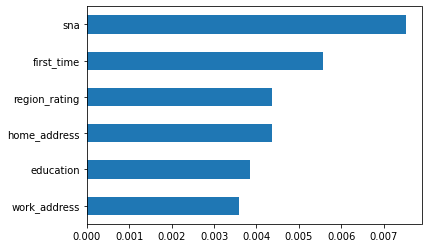

In [715]:
data_imp = data[data['train']==1]
imp_bin = Series(mutual_info_classif(data_imp[cat_cols], data_imp['default'], discrete_features=True), index = cat_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')

The most important feature is relation between borrower and bank

For categorical fetures we will be use LabelEncoder

In [716]:
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,3,0,1,9.798183,3,0,0,0.0,1
1,63161,2014-03-12,3,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,3,1,2,9.852247,3,0,0,0.0,1
2,25887,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,6,0,1,10.308986,0,3,1,0.0,1
3,16222,2014-01-23,3,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,3,1,2,9.210440,0,2,0,0.0,1
4,101655,2014-04-18,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,4,1,2,10.308986,0,3,1,0.0,1


Let see importance of our binary features

<AxesSubplot:>

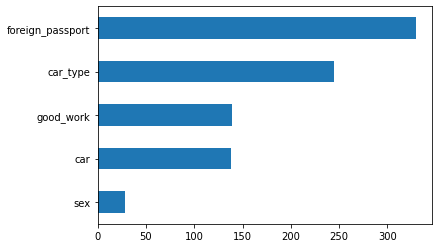

In [717]:
data_imp = data[data['train']==1]
imp_bin = Series(f_classif(data_imp[bin_cols], data_imp['default'])[0], index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')

The most important thing is having foreign passport

## 5. Features engineering

We have field with dates. Let's make new features with them.

In [718]:
data['app_day'] = data['app_date'].dt.day
data['app_weekday'] = data['app_date'].dt.weekday

data.drop(['app_date'], axis=1, inplace=True)

These features is categorical

In [719]:
cat_cols.append('app_day')
cat_cols.append('app_weekday')

For categorical features we create new data using dummies functionality

In [720]:
data = pd.get_dummies(data, columns=cat_cols)

## 6. Standardization

Standardization for numerical columns

In [721]:
st_num = StandardScaler()
data[num_cols] = st_num.fit_transform(data[num_cols])

## 7. Modeling

Let's make our first model

In [722]:
data_train = data[data['train'] == 1]
data_test = data[data['train'] == 0]

X = data_train.drop(['train', 'default', 'client_id'], axis=1)
Y = data_train['default']

data_train.shape, data_test.shape, X.shape

((73799, 77), (36349, 77), (73799, 74))

In [723]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [724]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 74), (14760, 74), (59039,), (14760,))

In [725]:
model_submission = LogisticRegression(max_iter=1000)
model_submission.fit(X_train, y_train)
predicted = model_submission.predict(X_test)
predicted_proba = model_submission.predict_proba(X_test)[:,1]

In [726]:
print('accuracy_score: {:.4f}'.format(accuracy_score(y_test, predicted)))
print('f1_score: {:.4f}'.format(f1_score(y_test, predicted)))
print('precision_score: {:.4f}'.format(precision_score(y_test, predicted)))
print('recall_score: {:.4f}'.format(recall_score(y_test, predicted)))
print('MSE: {:.4f}'.format(mean_squared_error(y_test, predicted)))

accuracy_score: 0.8749
f1_score: 0.0395
precision_score: 0.4000
recall_score: 0.0208
MSE: 0.1251


Accuracy is high, but we have so bad with f1_score (

Let's look at confusion matrix 

[[12876    57]
 [ 1789    38]]


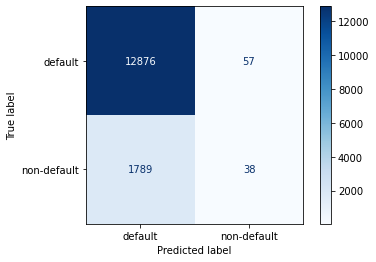

In [727]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(model_submission, X_test, y_test,
                                 display_labels=['default','non-default'],
                                 cmap=plt.cm.Blues)
print(disp.confusion_matrix)

Our model not so good in determine non-default clients. It means we will lost opportunities attract investment for bank.

Let's  look at ROC_AUC curve

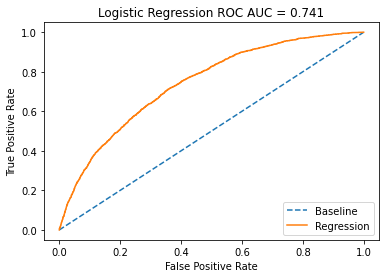

In [728]:
fpr, tpr, threshold = roc_curve(y_test, predicted_proba)
roc_auc = roc_auc_score(y_test, predicted_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Not so bad, but our mission to help bank to earn money

### 7.1 Oversampling 

One of the method to increase precision of our model it is using methods over-/undersampling

Lets look at distribution our classes

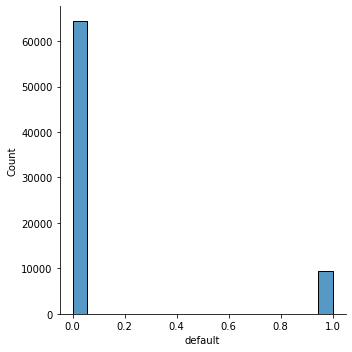

In [729]:
sns.displot(data_train['default'])

As we can see it's imbalane

In [730]:
data_train['default'].value_counts()

0.0    64427
1.0     9372
Name: default, dtype: int64

We find how many one class bigger than other

In [731]:
diff = floor(data_train['default'].value_counts()[0]/data_train['default'].value_counts()[1])

Increase lowest class

In [732]:
data_train_over = data_train.append([data_train[data_train['default'] == 1]]*diff, ignore_index=True)

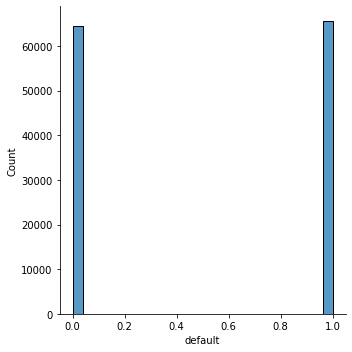

In [733]:
sns.displot(data_train_over['default'])

Lets train our model

In [734]:
X = data_train_over.drop(['train', 'default', 'client_id'], axis=1)
Y = data_train_over['default']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)[:,1]

print('accuracy_score: {:.4f}'.format(accuracy_score(y_test, predicted)))
print('f1_score: {:.4f}'.format(f1_score(y_test, predicted)))
print('precision_score: {:.4f}'.format(precision_score(y_test, predicted)))
print('recall_score: {:.4f}'.format(recall_score(y_test, predicted)))
print('MSE: {:.4f}'.format(mean_squared_error(y_test, predicted)))

accuracy_score: 0.6722
f1_score: 0.6762
precision_score: 0.6690
recall_score: 0.6835
MSE: 0.3278


Much better result means we on the right way

[[8581 4404]
 [4121 8901]]


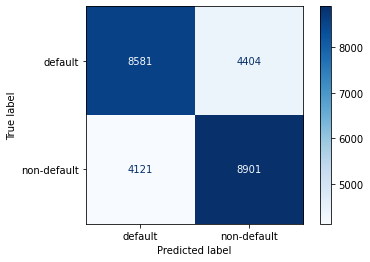

In [735]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=['default','non-default'],
                                 cmap=plt.cm.Blues)
print(disp.confusion_matrix)

But we haven't have nice result yet

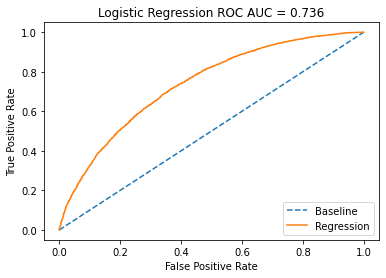

In [736]:
fpr, tpr, threshold = roc_curve(y_test, predicted_proba)
roc_auc = roc_auc_score(y_test, predicted_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### 7.2 Undersampling 

Another way to decrease biggest class

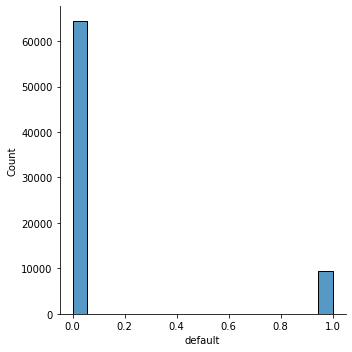

In [737]:
sns.displot(data_train['default'])

In [738]:
data_train['default'].value_counts()

0.0    64427
1.0     9372
Name: default, dtype: int64

In [739]:
data_zero = data_train[data_train['default'] == 0].iloc[:data_train['default'].value_counts()[1],:]
data_one = data_train[data_train['default'] == 1]
data_tarin_under = data_one.append(data_zero, ignore_index=True)

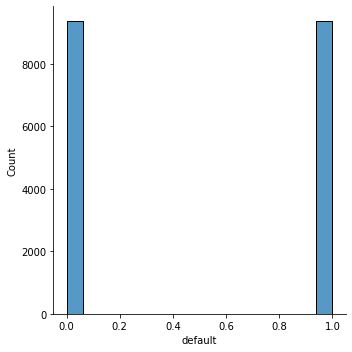

In [740]:
sns.displot(data_tarin_under['default'])

In [741]:
X = data_tarin_under.drop(['train', 'default', 'client_id'], axis=1)
Y = data_tarin_under['default']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)[:,1]

print('accuracy_score: {:.4f}'.format(accuracy_score(y_test, predicted)))
print('f1_score: {:.4f}'.format(f1_score(y_test, predicted)))
print('precision_score: {:.4f}'.format(precision_score(y_test, predicted)))
print('recall_score: {:.4f}'.format(recall_score(y_test, predicted)))
print('MSE: {:.4f}'.format(mean_squared_error(y_test, predicted)))

accuracy_score: 0.6724
f1_score: 0.6751
precision_score: 0.6741
recall_score: 0.6762
MSE: 0.3276


[[1245  617]
 [ 611 1276]]


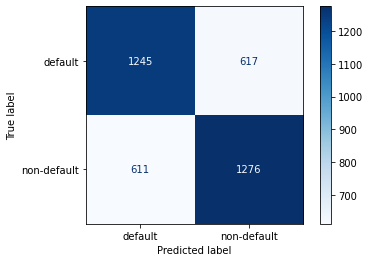

In [742]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=['default','non-default'],
                                 cmap=plt.cm.Blues)
print(disp.confusion_matrix)

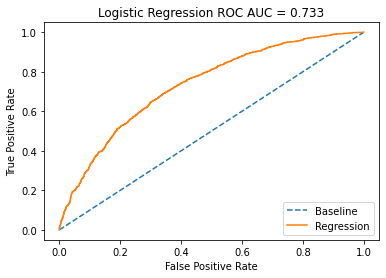

In [743]:
fpr, tpr, threshold = roc_curve(y_test, predicted_proba)
roc_auc = roc_auc_score(y_test, predicted_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

If we have less data, we'll get worse results

### 7.3 Hyperparameters

Another way it's to find such parameters our model which could enhance our predictive capability

In [744]:
warnings.simplefilter('ignore')

In [745]:
X = data_train_over.drop(['train', 'default', 'client_id'], axis=1)
Y = data_train_over['default']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# types of regularization
penalty = ['l1', 'l2']

# borders of regularization
C = np.logspace(0.5, 1, 3)

# Make hyperparameters
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Making search net with 5 cross validation
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 5.623413251903491


In [746]:
X = data_train_over.drop(['train', 'default', 'client_id'], axis=1)
Y = data_train_over['default']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
model = LogisticRegression(penalty='l2',C=5.6234)
model.fit(X_train, y_train)
predicted = model.predict(X_test)
predicted_proba = model.predict_proba(X_test)[:,1]

print('accuracy_score: {:.4f}'.format(accuracy_score(y_test, predicted)))
print('f1_score: {:.4f}'.format(f1_score(y_test, predicted)))
print('precision_score: {:.4f}'.format(precision_score(y_test, predicted)))
print('recall_score: {:.4f}'.format(recall_score(y_test, predicted)))
print('MSE: {:.4f}'.format(mean_squared_error(y_test, predicted)))

accuracy_score: 0.6721
f1_score: 0.6761
precision_score: 0.6689
recall_score: 0.6835
MSE: 0.3279


[[8579 4406]
 [4121 8901]]


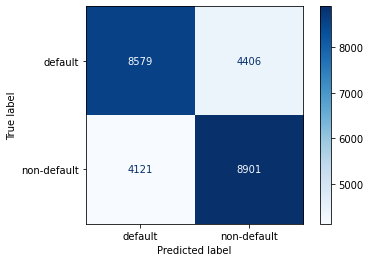

In [747]:
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=['default','non-default'],
                                 cmap=plt.cm.Blues)
print(disp.confusion_matrix)

Our parametrs could not improve predictive capabilities

## Brief summary
We can make conclusion that our predictive model has a problem with precision of results. And in spite of good results of ROC_AUC metrics we should try to enhance predictive capabilities by using another machine learning methods.

## 8. Submission

Lets make submission file

In [769]:
X_test = data_test.drop(['train', 'default','client_id'], axis=1)
predicted = model_submission.predict_proba(X_test)[:, 1]
submit = pd.DataFrame(data_test['client_id'])
submit['default'] = predicted
submit.to_csv('submission.csv', index=False)
submit = submit.reset_index().drop('index', axis=1)
submit.head()

,client_id,default
0,74835,0.041891
1,17527,0.287305
2,75683,0.078484
3,26883,0.087009
4,28862,0.023452
